In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

In [2]:
raw_data_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'

#E feature names (confirm with Nathan)
E_features_names = pd.read_csv(raw_data_pth+'sparse_pca_components_mMET_curated_Nov11_withheaders.csv')
E_features_names = E_features_names.columns[1:].values
E_feature_list = E_features_names.tolist()
E_feature_list.append('soma depth')

for i,e in enumerate(E_feature_list):
    e=e.replace('spiking','spike')
    e=e.replace('upstroke','up')
    e=e.replace('downstroke','down')
    e=e.replace('_',' ')
    #print(e)
    E_feature_list[i]=e
#Full data matrices
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
O2 = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_all.mat',squeeze_me=True)
O['gene_id']=O2['gene_id']
del O2

In [3]:
npp_genes = ['Vip','Npy','Sst','Penk','Tac2','Cck','Crh',
             'Tac1','Pdyn','Cort','Pthlh','Pnoc','Adcyap1',
             'Trh','Grp','Nmb','Nts','Rln1','Vipr1','Vipr2',
             'Npy1r','Npy2r','Npy5r','Sstr1','Sstr2',
             'Sstr3','Sstr4','Oprd1','Oprm1','Tacr3',
             'Cckbr','Crhr1','Crhr2','Tacr1','Oprk1',
             'Pth1r','Oprl1','Adcyap1r1','Trhr','Trhr2',
             'Grpr','Nmbr','Ntsr1','Ntsr2','Rxfp1','Rxfp2',
             'Rxfp3']

#Find location of all genes
gene_inds = []
for gene in npp_genes:
    ind = np.flatnonzero(np.isin(O['gene_id'],gene))
    if ind.size==1:
        gene_inds.append(ind[0])
gene_inds = np.array(gene_inds)
npp_genes_found = O['gene_id'][gene_inds].tolist()

In [4]:
csTE = '1-0'
aE = '1-0'
dir_pth={}
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
X = np.empty(shape=(9,E_features_names.size))
Y = np.empty(shape=(9,E_features_names.size))
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE_from_XT'][D['val_ind'],:-1]),axis=0)

In [5]:
csTE = '1-0'
aE = '1-0'
dir_pth={}
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
X = np.empty(shape=(9,gene_inds.size))
Y = np.empty(shape=(9,gene_inds.size))
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    inds = np.ix_(D['val_ind'],gene_inds)
    X[cv,:] = np.mean(np.square(O['T_dat'][inds] - D['XrT'][inds]),axis=0)
    Y[cv,:] = np.mean(np.square(O['T_dat'][inds] - D['XrT_from_XE'][inds]),axis=0)

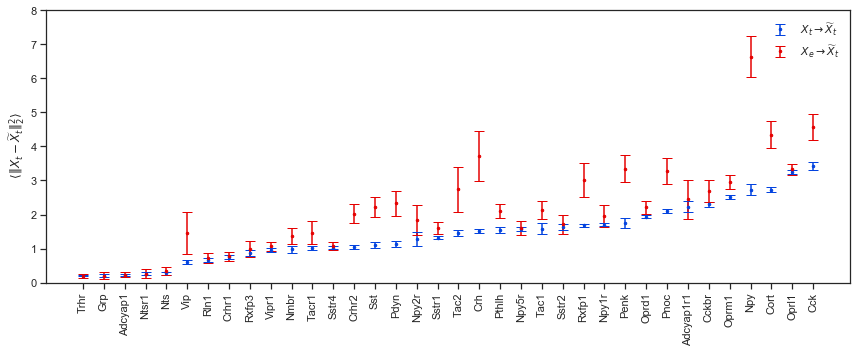

In [6]:
xx = np.arange(0,X.shape[1],1)

#With modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

#Cross modal prediction
yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)

cols = ['#0343df','#e50000']
fig = plt.figure(figsize=(12,5))

srtord = np.argsort(yy)
#srtord = np.arange(0,yy.size)
plt.errorbar(x=xx,y=yy[srtord],yerr=err[srtord],c=cols[0],capsize=5,ls='',marker='.',ms=5,label=r'$X_t \rightarrow \widetilde{X}_t$')
plt.errorbar(x=xx,y=yy2[srtord],yerr=err2[srtord],c=cols[1],capsize=5,ls='',marker='.',ms=5,label=r'$X_e \rightarrow \widetilde{X}_t$')
ax = plt.gca()
ax.set_xticks(np.arange(len(npp_genes_found)))
npp_genes_found_arr = np.array(npp_genes_found)
ax.set_xticklabels(npp_genes_found_arr[srtord],rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{t} - \widetilde{X}_{t} \Vert_2^2 \rangle $')
ax.set_ylim(0,8.0)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Tpred_crossmodal.png',dpi=300)

In [7]:
csTE = '1-0'
aE = '1-0'
dir_pth={}
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
cv=0
D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
#O['T_dat'][np.ix_(D['val_ind'],gene_inds)]

In [8]:
%matplotlib inline

In [9]:
gene_inds = gene_inds[srtord]
cell_ind=D['test_ind'][0]
for i in np.arange(0,D['test_ind'].size,10):
    cell_ind=D['test_ind'][i]
    plt.figure(figsize = (10,4))

    h1=plt.bar(x=np.arange(gene_inds.size)-0.2,
            height=D['XrT'][cell_ind,gene_inds],
            edgecolor='None',
            width=0.35,
            color='#0343df',alpha=0.8,align='center',
            label=r'Reconstruction from representation: $z_{t} \rightarrow \widetilde{X}_t$')

    h2=plt.bar(x=np.arange(gene_inds.size)+0.2,
            height=D['XrT_from_XE'][cell_ind,gene_inds],
            edgecolor='None',
            width=0.35,
            color='#e50000',alpha=0.8,align='center',
            label=r'Cross-modal reconstruction: $X_{me} \rightarrow \widetilde{X}_t$')

    h3=plt.bar(x=np.arange(gene_inds.size),
            height=O['T_dat'][cell_ind,gene_inds],
            width=0.8,
            color=(0.3,0.3,0.3,0.1),edgecolor='k',linewidth=1.5,align='center',
            label=r'Ground truth: $X_t$')

    ax = plt.gca()
    #plt.text(.5,.9,O['cluster'][cell_ind],
    #        horizontalalignment='center',
    #        transform=ax.transAxes,fontsize=12)
    ax.set_xticks(np.arange(gene_inds.size))
    ax.set_xticklabels(npp_genes_found_arr[srtord],rotation=90)
    ax.set_ylabel(r'$log_e(CPM+1)$')
    ax.set_ylim(0,11.0)
    #plt.legend(handles=[h3,h1,h2],labels=[h3.get_label(),h1.get_label(),h2.get_label()],fontsize=10,
    #           edgecolor='None',framealpha=0.2)
    plt.tight_layout()

    plt.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Test_T_'+str(i)+'_'+O['cluster'][cell_ind]+'.png',dpi=300)

    #---------------------------------------
    #---------------------------------------
    #Electrophysiology features-------------
    #---------------------------------------
    #---------------------------------------

    plt.figure(figsize = (12.5,5))

    h1=plt.bar(x=np.arange(len(E_feature_list))-0.2,
            height=D['XrE'][cell_ind,:],
            edgecolor='None',
            width=0.35,
            color='#0343df',alpha=0.8,align='center',
            label=r'Reconstruction from representation: $z_{me} \rightarrow \widetilde{X}_{me}$')

    h2=plt.bar(x=np.arange(len(E_feature_list))+0.2,
            height=D['XrE_from_XT'][cell_ind,:],
            width=0.35,
            color='#e50000',
            edgecolor='None',alpha=0.8,align='center',
            label=r'Cross-modal reconstruction: $X_{t} \rightarrow \widetilde{X}_{me}$')

    h3=plt.bar(x=np.arange(len(E_feature_list)),
               height=np.append(O['E_dat'][cell_ind,:],O['M_dat'][cell_ind]),
               width=0.8,
               color=(0.3,0.3,0.3,0.1),edgecolor='k',linewidth=1.5,align='center',
               label=r'Ground truth: $X_e$')

    ax = plt.gca()
    ax.set_xticks(np.arange(len(E_feature_list)))
    ax.set_xticklabels(E_feature_list,rotation=90)
    ax.set_ylabel(r'AU')
    ax.set_ylim(-3.5,3.5)
    #plt.legend(handles=[h3,h1,h2],
    #           labels=[h3.get_label(),h1.get_label(),h2.get_label()],
    #           fontsize=12,
    #           edgecolor='None',framealpha=0.2)
    plt.tight_layout()
    plt.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Test_E_'+str(i)+'_'+O['cluster'][cell_ind]+'.png',dpi=300)
    plt.close('all')

**Load all validation data and annotations**

In [10]:
%matplotlib inline

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 

In [12]:
csTE = '1-0'
aE = '1-0'
dir_pth={}
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
raw_data_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'

XrE = []
XrT = []
XrE_from_XT = []
XrT_from_XE = []
valind = []
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    valind.append(D['val_ind'])
    XrE.append(D['XrE'][D['val_ind'],:])
    XrT.append(D['XrT'][D['val_ind'],:])
    XrE_from_XT.append(D['XrE_from_XT'][D['val_ind'],:])
    XrT_from_XE.append(D['XrT_from_XE'][D['val_ind'],:])
valind = np.concatenate(valind,axis=0)
XrE = np.concatenate(XrE,axis=0)
XrT = np.concatenate(XrT,axis=0)
XrE_from_XT = np.concatenate(XrE_from_XT,axis=0)
XrT_from_XE = np.concatenate(XrT_from_XE,axis=0)

In [13]:
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)

In [14]:
from analysis_tree_helpers import HTree, Node, get_valid_classifications
import scipy.io as sio
import pandas as pd

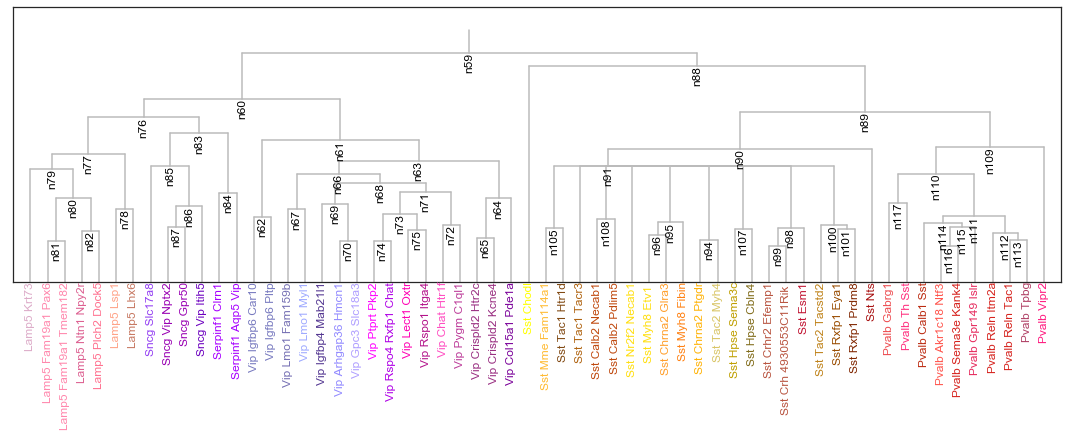

In [15]:
htree = HTree(htree_file='/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220.csv')
htree = htree.get_subtree(node='n59')
htree.plot((15,5),fontsize=12)
descendants = htree.get_all_descendants(leafonly=True)

In [16]:
grp_cols = [htree.col[htree.child=='Lamp5 Fam19a1 Tmem182'],
    htree.col[htree.child=='Sncg Slc17a8'],
    htree.col[htree.child=='Vip Igfbp4 Mab21l1'],
    htree.col[htree.child=='Sst Nr2f2 Necab1'],
    htree.col[htree.child=='Pvalb Reln Itm2a']]
grp_cols = np.concatenate(grp_cols)
grps = ['Lamp5','Sncg + Serpinf','Vip','Sst','Pvalb']
class_id = np.zeros((np.size(valind),))
for i,class_name in enumerate(['n77','n83','n61','n90','n109']):
    these_inds = np.isin(O['cluster'][valind],descendants[class_name])
    class_id[these_inds]=i

In [17]:
X = XrE[:,:-1]
Y = O['E_dat'][valind,:]
yref = np.mean((X-Y)**2,axis=0)
srtord = np.argsort(yref)

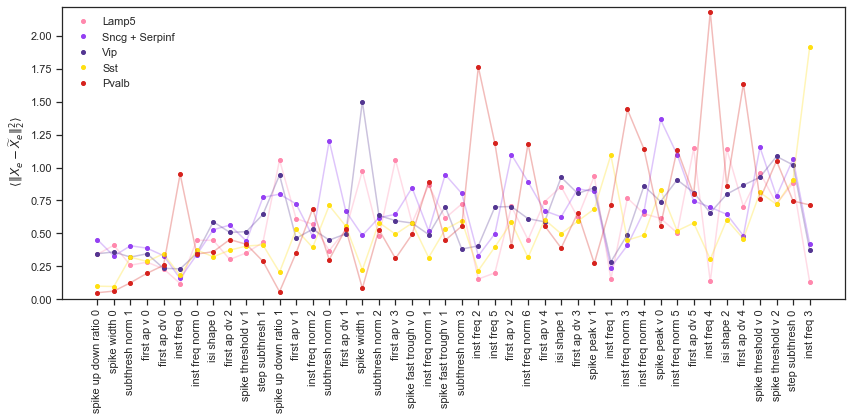

In [18]:
fig=plt.figure(figsize=(12,6))

for i,class_name in enumerate(['n77','n83','n61','n90','n109']):
    X = XrE[class_id==i,:-1]
    Y=O['E_dat'][valind[class_id==i],:]
    yy = np.mean((X-Y)**2,axis=0)
    xx = np.arange(44)
    plt.plot(xx,yy[srtord],color=grp_cols[i],linestyle='None',marker='.',markersize=8,label=grps[i])
    plt.plot(xx,yy[srtord],color=grp_cols[i],alpha=0.3)
ax = plt.gca()
ax.set_xticks(np.arange(len(E_feature_list[:-1])))
E_feature_names = np.array(E_feature_list[:-1])
E_feature_names = E_feature_names[srtord]
ax.set_xticklabels(E_feature_names,rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} - \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.22)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_cs_1-0_class-wise.png',dpi=300)

In [19]:
aE = '1-0'

X = np.empty(shape=(9,E_features_names.size))
Xcm = np.empty(shape=(9,E_features_names.size))
Y = np.empty(shape=(9,E_features_names.size))
Z = np.empty(shape=(9,E_features_names.size))
for cv in range(9):
    csTE = '1-0'    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    Xcm[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE_from_XT'][D['val_ind'],:-1]),axis=0) 

In [20]:


#Within modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

yy2=np.mean(Xcm,axis=0)
err2=np.std(Xcm,axis=0)/np.sqrt(Xcm.shape[0])

xx = np.arange(yy.size)

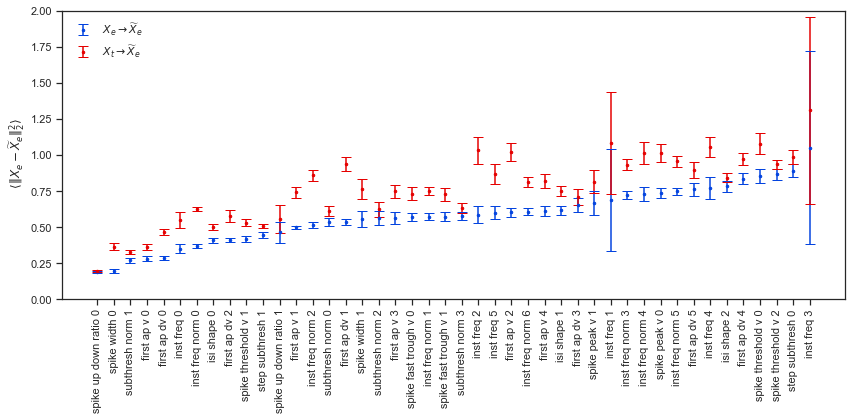

In [21]:
cols = ['#0343df','#e50000']
fig=plt.figure(figsize=(12,6))
srtord = np.argsort(yy)
#srtord = np.arange(0,yy.size)
plt.errorbar(xx,yy[srtord],err[srtord],c=cols[0],capsize=5,ls='',marker='.',ms=5,label=r'$X_{e} \rightarrow \widetilde{X}_e$')
plt.errorbar(xx,yy2[srtord],err2[srtord],c=cols[1],capsize=5,ls='',marker='.',ms=5,label=r'$X_{t} \rightarrow \widetilde{X}_e$')

ax = plt.gca()
ax.set_xticks(np.arange(len(E_feature_list[:-1])))
E_feature_names = np.array(E_feature_list[:-1])
ax.set_xticklabels(E_feature_names[srtord],rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} - \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.00)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_crossmodal.png',dpi=300)

In [22]:
X = np.random.normal(scale=1,size=(2000,1))
Y = np.random.normal(scale=1,size=(2000,1))
print('Baseline is random normal. MSE = {:0.3f}'.format(
    np.mean((X-Y)**2)))

X = np.random.normal(scale=1,size=(2000,1))
Y = np.random.normal(scale=1,size=(2000,1))
print('Baseline is constant=0. MSE = {:0.3f}'.format(
    np.mean((X-0)**2)))

Baseline is random normal. MSE = 1.970
Baseline is constant=0. MSE = 0.987
